In [ ]:
from scipy.io import loadmat
import numpy as np
import torch


In [ ]:
monkey_data = loadmat('monkey_data.mat') 
visual_data = monkey_data['inp'][0]
muscle_data = monkey_data['targ'][0]


In [ ]:
print(visual_data.shape)
print(visual_data[0].shape)
print(muscle_data.shape)

In [ ]:
batch_size = visual_data.shape[0]
trial_len = visual_data[0].shape[1]
in_dim = visual_data[0].shape[0]
out_dim = muscle_data[0].shape[0]

hid_dim = 100
num_layers = 3

In [ ]:
from sklearn.model_selection import train_test_split
np.random.seed()

 # shuffling was somehow change 
train_idx, test_idx = train_test_split(
     range(batch_size), 
     test_size=0.2, 
     shuffle=True )

# train_idx = range(0,401)
# test_idx= range(401,502)

print(len(train_idx))
print(len(test_idx))

train_dataset = [
    (torch.from_numpy(np.transpose(visual_data[i]).astype("float32")), torch.from_numpy(np.transpose(muscle_data[i]).astype("float32")))
    for i in train_idx
]

test_dataset = [
    (torch.from_numpy(np.transpose(visual_data[i]).astype("float32")), torch.from_numpy(np.transpose(muscle_data[i]).astype("float32")))
    for i in test_idx
]

print(train_dataset[0][0].shape)
print(train_dataset[0][0])




- ReTanh activation function --> tanh activation function
- rate regularization: 1e-1 --> they are regularizing the activity of the network!! the firing rate!! HOW
- weight regularization: 1e-5 --> well....
- intermodule sparsity: 0.1 -->
- Hessian free optimization -->

In [ ]:
from torch import nn

from mrnn import MilliesRNN
from hessianfree import HessianFree

learning_rate = 0.001
weight_d = 1e-5


model = MilliesRNN(in_dim, hid_dim, num_layers, out_dim)
criterion = nn.MSELoss()
optimizer = HessianFree(model.parameters(), use_gnm=True, verbose=True)
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_d)

num_epochs = 3
print_interval = 100
loss_error = []

for epoch in range(num_epochs):
    optimizer.zero_grad()
    # iteratring over time
    for i, (input, output) in enumerate(train_dataset): # 80% of 502 different examples

        gen_output, hn = model(input)        

        loss = criterion(gen_output, output)
        nn.utils.clip_grad_norm_(model.parameters(), 1)
        def closure():
            gen_output, _ = model(input)
            loss = criterion(gen_output, output)
            loss.backward(create_graph=True)
            return loss, gen_output
        optimizer.step(closure, M_inv=None)
        # add regularization loss with rate and weights here??
        # rate by taking L2 with matrix of zeroes
        loss_error.append(loss.item())
        
        if i == 0 or (i + 1) % print_interval == 0:
            print(
                f"Epoch [{epoch + 1}/{num_epochs}], "
                f"Step [{i + 1}/{len(train_dataset)}], "
                f"Loss: {loss.item():.4f}"
            )



Text(0, 0.5, 'mse loss')

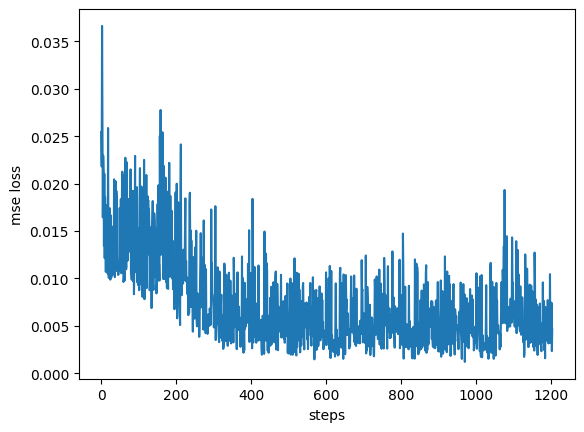

In [12]:
import matplotlib.pyplot as plt

plt.plot(loss_error)
plt.xlabel("steps")
plt.ylabel("mse loss")

Text(0, 0.5, 'mse loss')

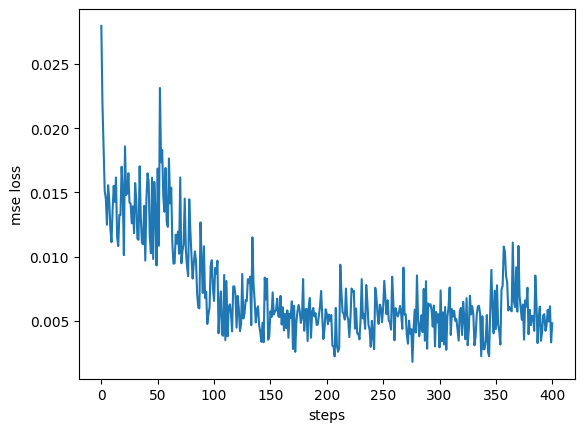

In [13]:
n=3
plt.plot(np.average(np.array(loss_error).reshape(-1, n), axis=1))
plt.xlabel("steps")
plt.ylabel("mse loss")

In [14]:
preds = torch.empty(batch_size, trial_len, out_dim)

num_correct = 0
num_samples = len(test_dataset)

model.eval()


total_loss = 0
with torch.no_grad():
    for (input, output) in test_dataset:
        out, hidden_state = model(input)
        loss = criterion(out, output)
        total_loss += loss

print(f"Average test loss: {total_loss / 101}")

Average test loss: 0.005557056050747633
